Web scraping project using mainly "snscrape", "nltk" and "emoji" libraries to scrape tweets from Twitter. Main topic is the #BlackLivesMatter movement that seeks to highlight racism, discrimination, and racial inequality experienced by black people. In this project, I decided to analyze the people's emotions behind the tweets. The code processes words in provided posts to analyze what people think about the movement.

In [2]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fetching tweets about #BlackLivesMatter. The function will fetch 100 tweets from each day between 2020-05-01 and 2021-05-01 (a full year) and save them in a csv file later on.

In [82]:
start_date = datetime.strptime('2020-05-01', '%Y-%m-%d')
end_date = datetime.strptime('2021-05-01', '%Y-%m-%d')
delta = timedelta(days=1)

tweets = []

while start_date <= end_date:
    query = f'#BlackLivesMatter since:{start_date.strftime("%Y-%m-%d")} until:{(start_date+delta).strftime("%Y-%m-%d")}'
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        if i >= 100:
            break
        tweets.append([tweet.id, tweet.date, tweet.user.username, tweet.rawContent, tweet.user.location, tweet.likeCount])
    start_date += delta

df = pd.DataFrame(tweets, columns=['id', 'date', 'username', 'content', 'location', 'likes'])
print(df.shape)

Empty user ref object in card on tweet 1279202507735158785
User 899733078641225728 not found in user refs in card on tweet 1279202507735158785
Unavailable user in card on tweet 1282101436109783040
Unavailable user in card on tweet 1282101436109783040
User 1596469960708165632 not found in user refs in card on tweet 1282101436109783040
User 1596469960708165632 not found in user refs in card on tweet 1282101436109783040
Unavailable user in card on tweet 1282101201002258432
Unavailable user in card on tweet 1282101201002258432
User 1596469960708165632 not found in user refs in card on tweet 1282101201002258432
User 1596469960708165632 not found in user refs in card on tweet 1282101201002258432
Twitter responded with an error: TimeoutError: Timeout: Unspecified
Twitter responded with an error: TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeou

(36600, 6)


Preprocessing words using lemmatization and tokenization.

Lemmatization is the process of converting a word to its base form. For example, lemmatization would correctly identify the base form of 'caring' to 'care', whereas stemming might simply chop off the 'ing' ending and call it a day. Lemmatization is computationally more expensive than stemming, but it tends to yield better results. It reduces the number of unique words in the vocabulary, which in turn reduces the computational burden of modeling.

Tokenization is the process of splitting a string into a list of tokens. A token can be thought of as a unit of parsing. For example, each word in a sentence can be considered a token, or each sentence in a paragraph can be considered a token. Tokenization is a necessary step in the process of preparing text for natural language processing.

The function also returns only words longer than 2 characters. This is to remove words like "is", "a", etc. that are not useful for the analysis.

In [83]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Deleting links
    text = re.sub(r'http\S+|www.\S+', '', text, flags=re.MULTILINE)
    # Deleting hashtags and mentions
    text = re.sub(r'#\S+|@\S+', '', text)
    # Tokenizing
    text = word_tokenize(text)
    # Lemmatize the word, remove stop words and words shorter than 2 letters as they have no meaning (there's a lot of them)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words and len(word) > 2]
    return text

df['processed_text'] = df['content'].apply(preprocess_text)

Emotion and sentiment analysis using "text2emotion" and "nltk" libraries. The code will analyze the emotions behind the tweets and the sentiment of the tweets. The sentiment analysis will be done using the "VADER" model from the "nltk" library. The VADER model is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. The VADER model is a pre-trained model that is trained on social media data and can be used to analyze sentiments in social media posts. The text2emotion groups the emotions into 5 categories: Happy, Angry, Surprise, Sad and Fear. The VADER model will give us the sentiment of the tweets in a score that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1  (most extreme positive).

In [84]:
nltk.download('vader_lexicon')

def emotion_analysis(text):
    emotions = te.get_emotion(' '.join(text))
    return emotions

def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    if isinstance(text, list):
        text = ' '.join(text)
    sentiment = sid.polarity_scores(text)
    return sentiment

df['sentiment'] = df['processed_text'].apply(sentiment_analysis)
df['emotions'] = df['processed_text'].apply(emotion_analysis)
df['sentiment'] = df['sentiment'].apply(lambda x: x['compound'])
df['emotions'] = df['emotions'].apply(lambda x: max(x, key=x.get))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Plots of the most common emotions overall, sentiment histogram (overall) and sentiment line chart over time (full year). On May 25th, 2020 - George Floyd was killed by a police officer in Minneapolis, Minnesota. This event sparked a global movement against racism and police brutality. The movement is called #BlackLivesMatter. The sentiment line on May 25th 2020, look really weird due to twitter taking actions after George Floyd's death. Many posts and accounts had to be banned because of the words used or opinions shared, buy you can clearly see that the sentiment was mostly negative on that day. There's a very significant difference between this date and the rest of the year.

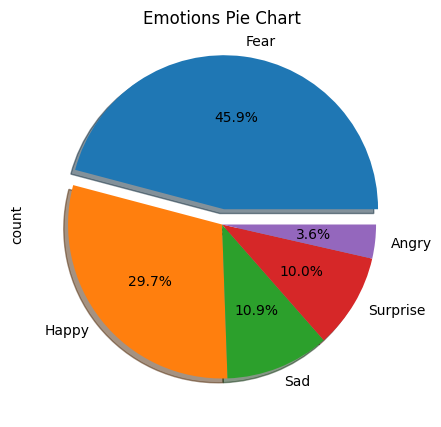

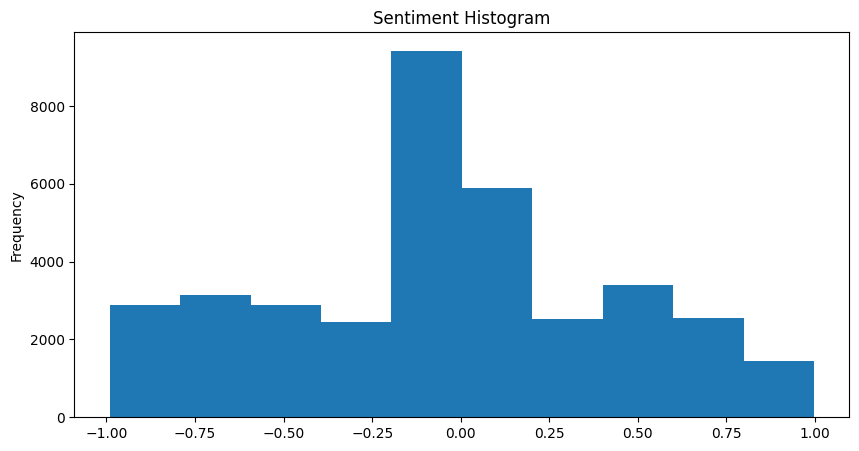

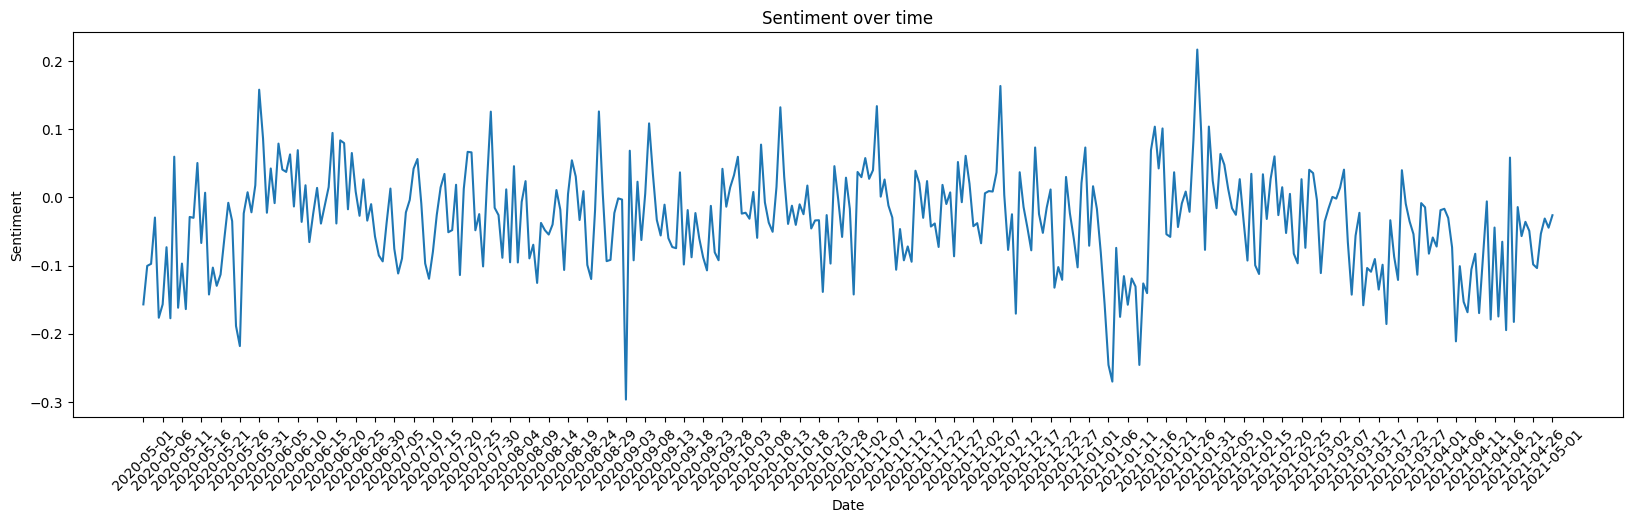

In [21]:
df = pd.read_csv('tweets.csv')
df['processed_text'] = df['processed_text'].apply(lambda x: eval(x))
df['date-grouped'] = df['date'].apply(lambda x: pd.Timestamp(x).floor('1D'))
df = df.sort_values(by='date-grouped')
# df.to_csv('tweets.csv', index=False)

# Pie chart for 'emotions'
plt.figure(figsize=(5,5))
df['emotions'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=[0.1, 0, 0, 0, 0], shadow=True)
plt.title('Emotions Pie Chart')
plt.show() 

# Histogram for 'sentiment'
plt.figure(figsize=(10,5))
df['sentiment'].plot(kind='hist')
plt.title('Sentiment Histogram')
plt.show()

# Line plot for 'sentiment' over time
df_agg = df.groupby('date-grouped')['sentiment'].mean().reset_index()
plt.figure(figsize=(20,5))
plt.title('Sentiment over time')
plt.plot(df_agg['date-grouped'], df_agg['sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.xticks(df_agg['date-grouped'][::5], rotation=45)
plt.show()


Statistic data for sentiment and emotions

In [86]:
# Wyniki dla sentymentu
sentiment_results = df['sentiment'].apply(pd.Series)
print(sentiment_results.describe())

# Wyniki dla emocji
emotion_results = df['emotions'].apply(pd.Series)
print(emotion_results.describe())

                  0
count  36600.000000
mean      -0.033899
std        0.470819
min       -0.991100
25%       -0.367050
50%        0.000000
75%        0.273200
max        0.997800
            0
count   36600
unique      5
top      Fear
freq    16793


Generating wordclouds for most positive and most negative words. The wordclouds are generated using the "wordcloud" library. It uses the sentiment scores of the tweets. The most positive words are the words with the highest sentiment scores and the most negative words are the words with the lowest sentiment scores. 

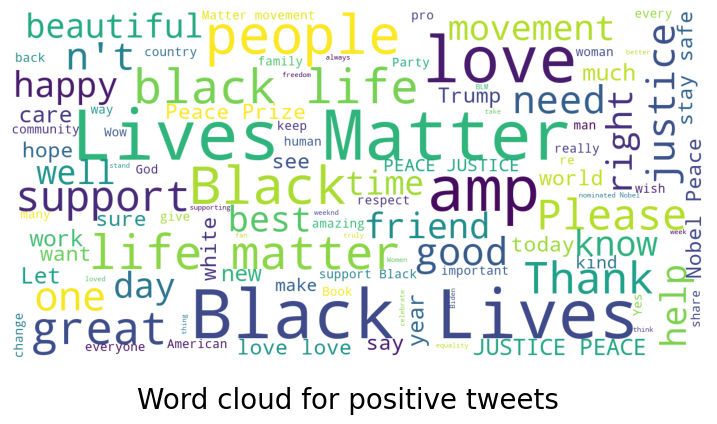

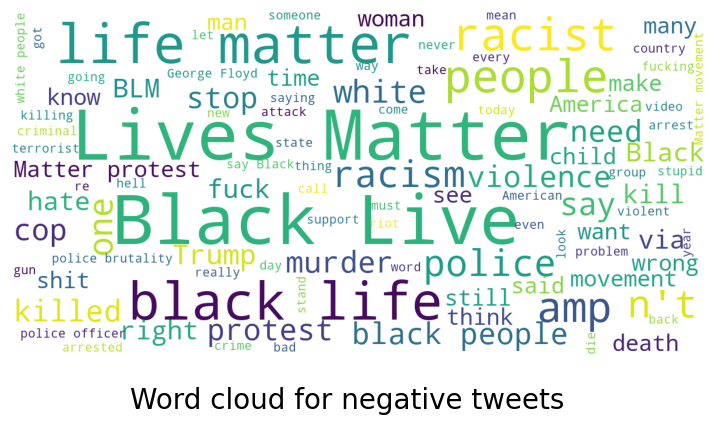

In [22]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=13
    ).generate(' '.join(data))

    fig = plt.figure(1, figsize=(9, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


def flatMap(arr):
    return [item for sublist in arr for item in sublist]

# Creating wordcloud for positive tweets
positive_tweets = flatMap(df[df['sentiment'] > 0.9]['processed_text'].tolist())
show_wordcloud(positive_tweets, title = "Word cloud for positive tweets")

# Creating wordcloud for negative tweets
negative_tweets = flatMap(df[df['sentiment'] < -0.7]['processed_text'].tolist())
show_wordcloud(negative_tweets, title = "Word cloud for negative tweets")

Bibliography:

[1.] https://en.wikipedia.org/wiki/Black_Lives_Matter

[2.] https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

[3.] https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/

[4.] https://en.wikipedia.org/wiki/Bag-of-words_model

[5.] https://www.teenvogue.com/story/august-28-black-history

[6.] https://edition.cnn.com/2021/01/07/us/police-response-black-lives-matter-protest-us-capitol/index.html